In [46]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

from scipy.io import loadmat
from sklearn.model_selection import train_test_split


def adatron(K,y0, eps=0.0001, t_max=1000):
    '''
    The AdaTron algorithm for SVM learning
    
    Parameters
    ----------
    K : PxP REAL MATRIX, where P is the training set size
        Contains all pairwise overlaps between training examples: X_ij= x_i*x_j
    y0 : Px1 REAL VECTOR
        All training labels, y_i = label(x_i)
    eps: FLOAT, optional
        Stopping criterion (when update<eps). The default is .0001
    t_max : INT, optional
        max runtime in epochs. The default is 1000.

    Returns
    -------
    hasConverged : BOOLEAN
        whether the algorithm converged (no more updates) or reached t_max and eas stopped.
    A : ExP REAL MATRIX, where E is the number of epochs
        Contains the P-dim support coefficient vectors (alpha) for all the epochs.
        A[t,:] is the support vector alpha_t (at epoch=t)
        When the algorithm has converges, A[-1,:] is the final result that defines the decision rule 

    '''
    P,P1= K.shape
    assert P==P1, "Kernel matrix K should be PxP, where P is the training set size"
    assert y0.size==P, "input-output set size mismatch"
    hasConverged = False
    epochs = 0
    A = []
    eta = 0.2/(np.max(np.linalg.norm(K,axis=0)))
    A.append(np.zeros((P,1)))
    # A.append(np.random.rand(P,1))
    
    while ((not hasConverged) and (epochs < t_max)):
        a = deepcopy(A[-1])
        for mu in range(P):
            y = y0[mu]
            coeff = y*(a*y0).T
            da = max(-a[mu], eta*(1-coeff@K[:,mu]))
            if np.isinf(da):
                print("stopping because of exploding updates, epoch={}, mu={}".format(epochs,mu))
                hasConverged = True
                continue;
            if np.isnan(da):
                print("nan")
                hasConverged = True
                continue;
            a[mu] += da
        A.append(a)
        diff = abs(A[-1]-A[-2])
        update_flag = np.max(diff) > eps
        hasConverged = hasConverged or (not update_flag)
        epochs += 1
        
    return hasConverged, np.squeeze(np.array(A))


def load_data():
    M = loadmat('data_10D.mat')
    return M['X'], M['w0'], M['y0']


def split_data(X, y, train_samples=5):    
    train_size = train_samples / len(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size)
    return X_train, X_test, y_train, y_test


def get_linear_kernel(X):
    return get_linear_kernel_of_matrices(X, X.T)


def get_linear_kernel_of_matrices(A, B):
    """
    Args:
        A: P1 X N
        B: N X P2
    Returns:
        P1 X P2 matrix
    """
    return np.dot(A, B)
    


(X, w0, y0) = load_data()

import math

def get_adatron_w(alphas, X_train, y_train):
    y_train_v = y_train.flat 
    new_y_train = (alphas * y_train_v)[alphas > 0]
    evaluation_matrix = X_train[alphas > 0] * new_y_train[:, np.newaxis]
    return np.sum(evaluation_matrix, axis=0)


def evaluate_adatron_model(alphas, X_train, y_train, X_test, y_test):
        y_train_v = y_train.flat 
        new_y_train = (alphas * y_train_v)[alphas > 0]
        evaluation_matrix = X_train[alphas > 0] * new_y_train[:, np.newaxis]
        test_predictions = np.sign(np.sum(get_linear_kernel_of_matrices(evaluation_matrix, X_test.T), axis=0))
        
        y_test_v = y_test.flat
        equal_indices = (y_test_v == test_predictions)
        return np.sum(equal_indices)/len(y_test_v)


def perceptron(X: np.ndarray, y0: np.ndarray, eta=0.1  , tmax=math.pow(10,3)):
    N, P = X.shape
    w = np.random.rand(N)
    converged = False

    for epoch in range(int(tmax)):
        dot_product = np.dot(X.T, w)

        y_pred = np.sign(dot_product).flatten()
        y_pred[y_pred == 0] = -1  # Replace 0 with -1 (as wrong prediction)
        misclassified = np.where(y_pred != y0)[0]

        if misclassified.size == 0:
            converged = True
            break

        update = np.sum(X[:, misclassified] * y0[misclassified], axis=1)
        w += eta*update

    return w, converged, epoch + 1
    

def evaluate_perceptron_model(w, X_test, y_test):
        test_predictions = np.sign(np.dot(X_test, w))
        equal_indices = (y_test == test_predictions)
        return np.sum(equal_indices)/len(y_test)


def cosine_distance(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2)
    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    cosine_distance = 1 - cosine_similarity
    return cosine_distance

In [74]:
import numpy as np
from pylab import scatter

def polynomial_kernel(X, c=1, d=2):
    """
    Compute the polynomial kernel matrix for a set of samples.

    Parameters:
    - X: P × N matrix (P samples, N dimensions)
    - c: Coefficient in the polynomial kernel
    - d: Degree of the polynomial kernel

    Returns:
    - K: P × P kernel matrix
    """
    K = np.dot(X, X.T) + c
    K = np.power(K, d)
    return K


def gaussian_kernel(X, sigma=1.0):
    """
    Compute the Gaussian (RBF) kernel matrix for a set of samples.

    Parameters:
    - X: P × N matrix (P samples, N dimensions)
    - sigma: Width parameter in the Gaussian kernel

    Returns:
    - K: P × P kernel matrix
    """
    pairwise_distances_sq = np.square(np.linalg.norm(X[:, np.newaxis] - X, axis=2))
    K = np.exp(-pairwise_distances_sq / (2 * sigma**2))
    return K


def checkboard(P):
   X=np.random.rand(2,P)
   p=np.mod(np.ceil(X*3),2)
   y0=2.*np.logical_xor(p[0,:],p[1,:])-1.
   return X,y0

def test_checkboard(x, y):
   scatter(x[0,y==-1.],x[1,y==-1.],c='r')
   scatter(x[0,y==1.],x[1,y==1.],c='b')


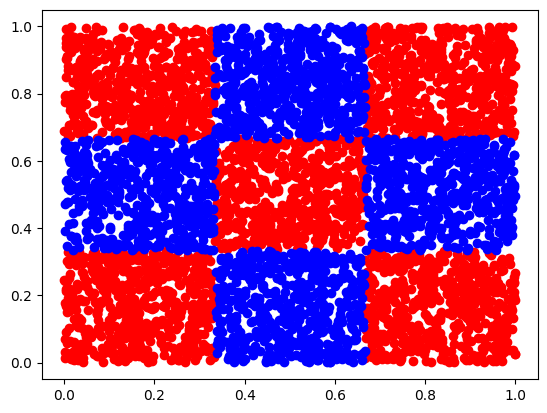

In [13]:
P_train = 1000
(X_train, y_train) = checkboard(P_train)
P_test = 5*P_train
(X_test, y_test) = checkboard(P_test)
test_checkboard(X_test, y_test)

In [ ]:
# 1.3

def predict_adatron_model(alphas, X_train, y_train, X_test):
        y_train_v = y_train.flat 
        new_y_train = (alphas * y_train_v)[alphas > 0]
        evaluation_matrix = X_train[alphas > 0] * new_y_train[:, np.newaxis]
        return np.sign(np.sum(get_linear_kernel_of_matrices(evaluation_matrix, X_test.T), axis=0))
        

P_train = 1000
(X_train, y_train) = checkboard(P_train)
y_train = y_train.reshape(-1,1)

P_test = 2000
(X_test, y_test) = checkboard(P_test)

# 
polynomial_kernel_degree = 5
# K = get_linear_kernel(X_train.T)
K = polynomial_kernel(X_train.T, d=polynomial_kernel_degree)
# K = gaussian_kernel(X_train.T, 0.3)
has_converged, A = adatron(K, y_train, t_max=math.pow(10, 5))
alphas = A[-1]

y_prediction = predict_adatron_model(alphas, X_train.T, y_train, X_test.T)

test_checkboard(X_test, y_prediction)









In [ ]:
# Create a 2D array (matrix)
matrix = np.array([[1, 2],
                   [4, 5],
                   [7, 8]])

# Create a 1D vector
vector = np.array([[2, 3],[2000, 3000], [2000, 3000], [2000, 3000], [2000, 3000], [2000, 3000]])

# Multiply each row of the matrix by the corresponding value from the vector
np.dot(matrix, vector.T)

In [ ]:
np.sign(np.sum(np.dot(matrix, vector.T), axis=0))

In [73]:
matrix = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])

# Raise each element of the matrix to the power of 2
np.power(matrix, 2)

array([[ 1,  4,  9],
       [16, 25, 36],
       [49, 64, 81]])